In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

#####

import json
import bisect
import itertools

import ephem
import datetime

import pprint
pp = pprint.PrettyPrinter(indent=4)

from operator import attrgetter

from tvgutil import contact_plan as cp, tvg

with open("../cache.out/diss_eval/jan_2020_7-28.02.scenario.json", "r") as f:
    scenario = json.load(f)
      
gs_list = scenario["gslist"]
sat_list = scenario["satlist"]

with open("../cache.out/diss_eval/jan_2020_7-28.02.ftvg.json", "r") as f:
    ftvg = tvg.from_serializable(json.load(f))
    
fcp = tvg.to_contact_plan(ftvg)

print(f"Loaded scenario: {len(gs_list)} gs, {len(sat_list)} sat")
print(f"FCP has len = {len(fcp)}")
print(f"F-TVG has {len(ftvg.vertices)} vertices and {len(ftvg.edges)} edges")

from predictutil import SatelliteTrajectoryPredictor

trajectory_predictors = {
        frozenset((gs["id"], sat["id"])): SatelliteTrajectoryPredictor(
            sat["id"],
            sat["tle_list"],
            gs["lat"],
            gs["lon"],
            gs["alt"],
        )
        for gs, sat in itertools.product(gs_list, sat_list)
}

Loaded scenario: 6 gs, 3 sat
FCP has len = 1282
F-TVG has 9 vertices and 36 edges


In [4]:
for gs in gs_list:
    for sat in sat_list:
        print(gs["id"], sat["id"], len(ftvg.edges[(gs["id"], sat["id"])]))
        
np.mean([(c.end_time - c.start_time) for c in fcp])

KB9JHU NOAA 15 22
KB9JHU NOAA 18 19
KB9JHU NOAA 19 20
N5CNB-VHF NOAA 15 66
N5CNB-VHF NOAA 18 53
N5CNB-VHF NOAA 19 80
F6KKR NOAA 15 87
F6KKR NOAA 18 44
F6KKR NOAA 19 104
MW6CYK NOAA 15 24
MW6CYK NOAA 18 21
MW6CYK NOAA 19 18
Um Alaish 4 NOAA 15 10
Um Alaish 4 NOAA 18 16
Um Alaish 4 NOAA 19 13
DL6KBG (VHF) NOAA 15 15
DL6KBG (VHF) NOAA 18 15
DL6KBG (VHF) NOAA 19 14


836.1302652106084

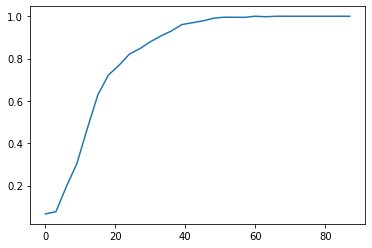

In [2]:
def get_decodability_histogram(fcp_cur, elevation_granularity=3, ber_threshold=1e-6, az_filter=None):
    elevation_range = list(range(0, 90, elevation_granularity))
    ber_bucks = np.array([0. for _ in elevation_range])
    all_bucks = np.array([0. for _ in elevation_range])
    for fc in fcp_cur:
        tp = trajectory_predictors[frozenset((fc.tx_node, fc.rx_node))]
        for i, char in enumerate(fc.characteristics):
            char_start = max(fc.start_time, char.starting_at)
            char_end = fc.characteristics[i + 1].starting_at if i + 1 < len(fc.characteristics) else fc.end_time
            if char_end <= char_start:
                continue
            char_mean = 0.5 * (char_start + char_end)
            char_duration_sec = char_end - char_start
            elev = tp.predict_elevation(char_mean) / math.pi * 180
            if az_filter:
                az = tp.predict_azimuth(char_mean) / math.pi * 180
                if az < az_filter[0] or az >= az_filter[1]:
                    continue
            if char.bit_error_rate <= ber_threshold:
                ber_bucks[int(elev / elevation_granularity)] += char_duration_sec
            all_bucks[int(elev / elevation_granularity)] += char_duration_sec
    return elevation_range, ber_bucks, all_bucks

# Ratio that can be successfully decoded -- over all
elev, ber_bucks, all_bucks = get_decodability_histogram(fcp)
plt.plot(elev, ber_bucks / all_bucks)

<ipython-input-3-f540c65a03ea>:14: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(elev, ber_bucks / all_bucks, label=gs["id"])
<ipython-input-3-f540c65a03ea>:16: RuntimeWarning: invalid value encountered in true_divide
  res = scipy.optimize.curve_fit(fit_fun, elev, ber_bucks / all_bucks)


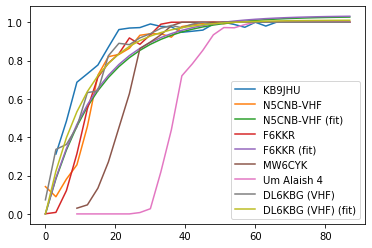

In [3]:
# overall GS quality evaluation

# NOTE: function seems to be roughly: a * (1 - exp(-b * x))
# ...with the asymptote a in [0; 1] and the scaling/rise factor b > 0

import scipy.optimize

def fit_fun(e, a, b):
    return a * (1 - np.exp(-b * e))

for gs in gs_list:
    p = ftvg.edges[(gs["id"], "NOAA 15")] + ftvg.edges[(gs["id"], "NOAA 18")] + ftvg.edges[(gs["id"], "NOAA 19")]
    elev, ber_bucks, all_bucks = get_decodability_histogram(p)
    plt.plot(elev, ber_bucks / all_bucks, label=gs["id"])
    try:
        res = scipy.optimize.curve_fit(fit_fun, elev, ber_bucks / all_bucks)
        plt.plot(elev, [fit_fun(e, res[0][0], res[0][1]) for e in elev], label=(gs["id"] + " (fit)"))
    except ValueError:
        pass
plt.legend()

In [ ]:
# determine minimum elevation

dh = {}
az_granularity = 45
elev_granularity = 6

ber_thresh = 1e-5
# 20 % of the time the BER should be below the threshold
min_ratio = 0.2

for gs in gs_list:
    p = ftvg.edges[(gs["id"], "NOAA 15")] + ftvg.edges[(gs["id"], "NOAA 18")] + ftvg.edges[(gs["id"], "NOAA 19")]
    dh[gs["id"]] = []
    for az in range(0, 360, az_granularity):
        elev, ber_bucks, all_bucks = get_decodability_histogram(
            p,
            ber_threshold=ber_thresh,
            elevation_granularity=elev_granularity,
            az_filter=(az, az + az_granularity)
        )
        dh[gs["id"]].append(ber_bucks / all_bucks)

dh2 = {
    k: [(az_granularity * i, elev[np.argwhere(arr > min_ratio)[0][0]]) for i, arr in enumerate(v)]
    for k, v in dh.items()
}

for gs, vals in dh2.items():
    plt.polar(
        [x[0] / 180 * math.pi for x in vals] + [vals[0][0]],
        [x[1] for x in vals] + [vals[0][1]],
        label=gs
    )
plt.legend()

In [ ]:
def get_mean_ber(fcp_cur, elevation_granularity=3, az_filter=None):
    elevation_range = list(range(0, 90, elevation_granularity))
    ber_bucks = [[] for _ in elevation_range]
    for fc in fcp_cur:
        tp = trajectory_predictors[frozenset((fc.tx_node, fc.rx_node))]
        for char in fc.characteristics:
            elev = tp.predict_elevation(char.starting_at) / math.pi * 180
            if az_filter:
                az = tp.predict_azimuth(char.starting_at) / math.pi * 180
                if az < az_filter[0] or az >= az_filter[1]:
                    continue
            ber_bucks[int(elev / elevation_granularity)].append(char.bit_error_rate)
    return elevation_range, ber_bucks

for gs in gs_list:
    p = ftvg.edges[(gs["id"], "NOAA 15")] + ftvg.edges[(gs["id"], "NOAA 18")] + ftvg.edges[(gs["id"], "NOAA 19")]
    elev, bucks = get_mean_ber(p, 10)
    plt.plot(elev, [np.mean(x) for x in bucks], label=(gs["id"] + " (mean)"))
    plt.plot(elev, [np.median(x) for x in bucks], label=(gs["id"] + " (median)"))
    
plt.legend()

In [ ]:
for gs in gs_list:
    p = ftvg.edges[(gs["id"], "NOAA 15")] + ftvg.edges[(gs["id"], "NOAA 18")] + ftvg.edges[(gs["id"], "NOAA 19")]
    elev, bucks = get_mean_ber(p, 10)
    plt.plot(elev, [np.std(x) for x in bucks], label=gs["id"])
    
plt.legend()

In [ ]:
# test of inverting the SNR relationship
# NOTE: does not work if using ber after coding...

import scipy.special

def _ber_to_ebn0_bfsk(ber):
    # ber for bfsk: 1/2erfc(sqrt(eb/2n0))
    # see: https://www.atlantarf.com/FSK_Modulation.php
    return min(60, 2 * (scipy.special.erfcinv(2 * ber) ** 2))

plt.plot([_ber_to_ebn0_bfsk(c.bit_error_rate) for c in fcp[120].characteristics])

In [5]:
from predictutil import get_contact, predict_rr0_for_scenario, get_fc_volume

from tvgutil import contact_plan

scenario_start = min(fcp, key=attrgetter("start_time")).start_time
scenario_end = max(fcp, key=attrgetter("end_time")).end_time

rr0_contacts = predict_rr0_for_scenario(
    gs_list,
    sat_list,
    scenario_start,
    scenario_end,
    0,  # NOTE: minelev for PCP is 0 because we modify the predictions!
)
rr0_contacts = [
    (gs, sat, start, end)
    for gs, sat, start, end in rr0_contacts
    if get_contact(ftvg.edges.get((gs, sat), []), start, end)
]
# WARNING: uplink_rate is from first entry of tuple to second (GS -> Sat)
pcp = contact_plan.contact_tuples_to_pcp(
    rr0_contacts,
    0.0,
    uplink_rate=scenario["bit_rate_uplink"],
    downlink_rate=scenario["bit_rate_downlink"],
)
ptvg = tvg.from_contact_plan(pcp)

def __get_drf(char, start_time, end_time):
    value = 0.0
    for i, c in enumerate(char):
        # The first characteristics entry might be valid earlier than the
        # contact starts. This ensures we only take into account the
        # contact time frame itself.
        char_start = max(
           start_time,
           c[0],
        )
        try:
            char_end = min(
                end_time,
                char[i + 1][0],
            )
        except IndexError:
            # The end of the last entry is the contact end time.
            char_end = end_time
        if char_end <= char_start:
            continue
        value += (char_end - char_start) * c[1]
        if char_end == end_time:
            break
    return value / (end_time - start_time)

In [7]:
len(predict_rr0_for_scenario(
    gs_list,
    sat_list,
    scenario_start,
    scenario_end,
    0,  # NOTE: minelev for PCP is 0 because we modify the predictions!
))

2764

In [ ]:
from predictutil.volume import VolumePredictor
import collections

class MinElevationVolumePredictor2(VolumePredictor):

    def __init__(self, trajectory_predictor, min_elevation=5):
        super().__init__(trajectory_predictor)
        self.min_elevation = min_elevation

    def predict_data_rate_factors(self, at_time, soft_start, soft_end):
        contacts = self.trajectory_predictor.predict_contacts_ex(
            at_time,
            soft_start,
            soft_end,
            self.min_elevation,
        )
        assert len(contacts) <= 1
        if not contacts:
            return [(0, 0.0)]
        elev_start_time, elev_end_time = contacts[0]
        #assert elev_end_time - elev_start_time <= soft_end - soft_start
        center_offset = (
            (elev_end_time + elev_start_time) / 2 -
            (soft_end + soft_start) / 2
        )
        # Return prediction moved into provided interval
        return [
            (0, 0.0),
            (elev_start_time - center_offset, 1.0),
            (elev_end_time - center_offset, 0.0),
        ]
    
    
class MinElevationVolumePredictor3(VolumePredictor):

    def __init__(self, trajectory_predictor, min_elevation=5):
        super().__init__(trajectory_predictor)
        self.min_elevation = min_elevation
        
    def get_angular_sgp4(self, time):
        sgp4 = self.trajectory_predictor.get_sgp4(time)
        
        def f(t):
            e, a = sgp4(t)
            return float(e) * 180 / math.pi, float(a) * 180 / math.pi
    
        return f

    def predict_data_rate_factors(self, at_time, soft_start, soft_end):
        elev = self.min_elevation 
        sgp4 = self.get_angular_sgp4(at_time)
        elev_start_time, elev_end_time = get_contact_within(sgp4, soft_start, soft_end, elev, elev)
        if not elev_start_time or not elev_end_time:
            return [(0, 0.0)]
        center_offset = (
            (elev_end_time + elev_start_time) / 2 -
            (soft_end + soft_start) / 2
        )
        # Return prediction moved into provided interval
        return [
            (0, 0.0),
            (elev_start_time - center_offset, 1.0),
            (elev_end_time - center_offset, 0.0),
        ]
    
class EwmaAverager:
    
    def __init__(self, weight, init_value):
        self.weight = weight
        self.value = init_value
        
    def add_value(self, value):
        self.value = (
            (1 - self.weight) * self.value +
            self.weight * value
        )
    
    def get_average(self):
        return self.value
    
    def export_state(self):
        return [self.weight, self.value]
    
    def import_state(self, val):
        self.weight = val[0]
        self.value = val[1]
        
    def copy(self):
        e = EwmaAverager(self.weight, self.value)
        e.import_state(self.export_state())
        return e

class WindowAverager:
    
    def __init__(self, window_size, default_value):
        self.window_size = int(window_size)
        self.default_value = default_value
        self.window = collections.deque(maxlen=self.window_size)
        
    def add_value(self, value):
        self.window.append(value)
    
    def get_average(self):
        if not self.window:
            return self.default_value
        return np.median(self.window) 
        # FIXME
        return sum(self.window) / len(self.window)
    
    def export_state(self):
        return [self.window_size, self.default_value, list(self.window)]
    
    def import_state(self, val):
        self.window_size = int(val[0])
        self.default_value = val[1]
        self.window = collections.deque(val[2], maxlen=self.window_size)
        
    def copy(self):
        e = WindowAverager(self.window_size, self.default_value)
        e.import_state(self.export_state())
        return e
        

class MinElevDetectionVolumePredictor2(VolumePredictor):

    def __init__(self, trajectory_predictor, link_block_size,
                 elev_averager, quality_averager):
        super().__init__(trajectory_predictor)
        self.link_block_size = link_block_size
        self.default_predictor = MinElevationVolumePredictor2(
            trajectory_predictor,
            10,
        )
        self.elev_averager = elev_averager
        self.quality_averager = quality_averager
        self.observed_contacts = 0

    def _get_decodability_histogram(self, fc, elevation_granularity=3,
                                    ber_threshold=1e-6, az_filter=None):
        elevation_range = list(range(0, 90, elevation_granularity))
        ber_bucks = np.array([0. for _ in elevation_range])
        all_bucks = np.array([0. for _ in elevation_range])
        tp = self.trajectory_predictor
        for i, char in enumerate(fc.characteristics):
            char_start = max(fc.start_time, char.starting_at)
            char_end = (
                fc.characteristics[i + 1].starting_at
                if i + 1 < len(fc.characteristics)
                else fc.end_time
            )
            if char_end <= char_start:
                continue
            char_mean = 0.5 * (char_start + char_end)
            char_duration_sec = char_end - char_start
            elev = tp.predict_elevation(char_mean) / math.pi * 180
            if az_filter:
                az = tp.predict_azimuth(char_mean) / math.pi * 180
                if az < az_filter[0] or az >= az_filter[1]:
                    continue
            buck_index = int(elev / elevation_granularity)
            if char.bit_error_rate <= ber_threshold:
                ber_bucks[buck_index] += char_duration_sec
            all_bucks[buck_index] += char_duration_sec
        return elevation_range, ber_bucks, all_bucks

    def observe_contact(self, fc):
        # fc_volume = get_fc_volume(cur_fc, self.link_block_size)

        MIN_SAMPLE_SEC = 25
        MIN_GOOD_RATIO = 0.2  # % of the sample interval have to be "good"
        BLOCK_SUCCESS_PROB = 0.5  # determines the BER threshld for which we consider a sample "good"

        thresh = (1 - (1 - BLOCK_SUCCESS_PROB) ** (1 / self.link_block_size))
        #print(thresh)
        elev_range, ber_bucks, all_bucks = self._get_decodability_histogram(
            fc,
            # BER where decoding of block is > 80%
            ber_threshold=thresh,
        )
        first_good_elev = None
        for i, elev in enumerate(elev_range):
            if all_bucks[i] < MIN_SAMPLE_SEC:
                #print(all_bucks[i])
                continue
            if ber_bucks[i] / all_bucks[i] > MIN_GOOD_RATIO:
                first_good_elev = elev
                break

        if first_good_elev is not None:
            # get interval with new elev estimation!
            contacts = self.trajectory_predictor.predict_contacts(
                fc.start_time,
                fc.end_time,
                first_good_elev,
            )
            assert len(contacts) <= 1
            if not contacts:
                # WARNING: seems the calculation was bad...
                print(f"ERR: {fc}")
                return
            t0, t1 = contacts[0]
            if t0 < fc.start_time:
                t0 = fc.start_time
            if t1 > fc.end_time:
                t1 = fc.end_time
            # estimate ratio of bit rate achieved on average -> quality
            bit_rate = fc.get_characteristics_at(fc.start_time).bit_rate
            maxvol = bit_rate * (t1 - t0)
            # NOTE: we use the volume of the WHOLE contact, but expect the volume during the minelev interval
            vol = get_fc_volume(fc, self.link_block_size)
            #vol = get_fc_volume_intv(fc, t0, t1, self.link_block_size)
            #print(f"{vol / maxvol} - {fc}")
            quality = min(2.0, vol / maxvol)
            #print(f"qup: {quality}")
            # update quality
            self.quality_averager.add_value(quality)
            # upate minelev
            self.elev_averager.add_value(first_good_elev)
            self.observed_contacts += 1

    def predict_data_rate_factors(self, at_time, soft_start, soft_end):
        self.default_predictor.min_elevation = self.elev_averager.get_average()
        print(self.default_predictor.min_elevation)
        self.default_predictor.min_elevation = max(0, self.default_predictor.min_elevation)
        drf = self.default_predictor.predict_data_rate_factors(
            at_time,
            soft_start,
            soft_end,
        )
        if len(drf) != 1:
            assert len(drf) == 3
            #print(self.quality_during_window)
            drf[1] = (drf[1][0], self.quality_averager.get_average())
        return drf

    def export_metric_info(self):
        return self.min_elevation, self.observed_contacts

    def import_metric_info(self, mi):
        logger.debug("Importing elev = %f sourced from %d contacts", *mi)
        self.min_elevation, self.observed_contacts = mi

    
def get_fc_volume_intv(factual_contact, t0, t1, block_size):
    assert t0 >= factual_contact.start_time
    assert t1 <= factual_contact.end_time
    volume = 0
    t = t0
    while t < t1:
        char = factual_contact.get_characteristics_at(t)
        p_block_successfully_transmitted = (
            (1 - char.bit_error_rate) ** block_size
        )
        tx_duration = block_size / char.bit_rate
        if t + tx_duration > t1:
            break
        volume += block_size * p_block_successfully_transmitted
        t += tx_duration
    return volume


class TriStateVolumePredictor(VolumePredictor):

    def __init__(self, trajectory_predictor, good_averager, good_q_averager, link_block_size=12000,
                 min_elevation=10, az_granularity=45):
        super().__init__(trajectory_predictor)
        self.link_block_size = link_block_size
        self.default_predictor = MinElevationVolumePredictor2(
            trajectory_predictor,
            min_elevation,
        )
        self.min_bad_elevations = [None for _ in range(360 // az_granularity)]
        self.az_granularity = az_granularity
        self.good_averager = good_averager
        self.good_q_averager = good_q_averager
        self.observed_good_contacts = 0
        self.observed_bad_contacts = [0 for _ in range(360 // az_granularity)]
        self.next_value_weight = 0.4
        
    def get_angular_sgp4(self, time):
        sgp4 = self.trajectory_predictor.get_sgp4(time)
        
        def f(t):
            e, a = sgp4(t)
            return float(e) * 180 / math.pi, float(a) * 180 / math.pi
    
        return f

    def observe_contact(self, fc):
        SAMPLE_DURATION = 30
        MIN_GOOD_RATIO = 0.9
        MIN_BAD_RATIO = 0.5
        
        # NOTE: It is important that the FTVG only records link quality reductions as an increased BER!
        bit_rate = fc.get_characteristics_at(fc.start_time).bit_rate
        
        # We want the predictor associated to the FC. As start_time may be imprecise we use the end to get it definitely.
        sgp4 = self.get_angular_sgp4(fc.end_time)
        
        start_az = float(sgp4(fc.start_time)[1])
        end_az = float(sgp4(fc.start_time)[1])
        
        t0 = fc.start_time
        good_start_elev = None
        good_end_elev = None
        bad_start_elev = None
        bad_end_elev = None
        good_int_volume = 0
        good_max_volume = 0
        in_good = False
        good_between_int_volume = 0
        good_between_max_volume = 0
        was_good = False
        while t0 < fc.end_time:
            t1 = t0 + SAMPLE_DURATION
            if t1 > fc.end_time:
                break
            maxvol = bit_rate * (t1 - t0)
            intvol = get_fc_volume_intv(fc, t0, t1, self.link_block_size)
            #print(intvol / maxvol)
            ratio = intvol / maxvol
            elev0 = float(sgp4(t0)[0])
            elev1 = float(sgp4(t1)[0])
            if ratio < MIN_BAD_RATIO:
                t0 += SAMPLE_DURATION
                continue
            if bad_start_elev is None:
                bad_start_elev = elev0
            bad_end_elev = elev1
            if ratio < MIN_GOOD_RATIO:
                if in_good:
                    in_good = False
                    was_good = True
                    good_between_int_volume = 0
                    good_between_max_volume = 0
                else:
                    if was_good:
                        good_between_int_volume += intvol
                        good_between_max_volume += maxvol
                    t0 += SAMPLE_DURATION
                    continue
            if good_start_elev is None:
                if not in_good:
                    in_good = True
                    t0 += SAMPLE_DURATION
                    # add the "bad volume in between"
                    good_int_volume += good_between_int_volume
                    good_max_volume += good_between_max_volume
                    continue
                good_start_elev = elev0
            in_good = True
            good_end_elev = elev1
            good_int_volume += intvol
            good_max_volume += maxvol
            t0 += SAMPLE_DURATION
            
        if bad_start_elev is None:
            #print(f"Skipping {fc}")
            return
        
        start_az_i = int(start_az // self.az_granularity)
        end_az_i = int(end_az // self.az_granularity)
        self.observed_bad_contacts[start_az_i] += 1
        self.observed_bad_contacts[end_az_i] += 1
        
        if self.min_bad_elevations[start_az_i] is None:
            self.min_bad_elevations[start_az_i] = bad_start_elev
        else:
            self.min_bad_elevations[start_az_i] = (
                (1 - self.next_value_weight) * self.min_bad_elevations[start_az_i] +
                self.next_value_weight * bad_start_elev
            )
            
        if self.min_bad_elevations[end_az_i] is None:
            self.min_bad_elevations[end_az_i] = bad_end_elev
        else:
            self.min_bad_elevations[end_az_i] = (
                (1 - self.next_value_weight) * self.min_bad_elevations[end_az_i] +
                self.next_value_weight * bad_end_elev
            )

        if good_start_elev is None:
            #print(f"Nothing good in {fc}, bad1 = {bad_start_elev}, bad2 = {bad_end_elev}")
            return
        
        self.observed_good_contacts += 1
        
        print(bad_start_elev, good_start_elev, good_end_elev, bad_end_elev)
        
        good_start_elev = max(good_start_elev, 20)
        good_end_elev = max(good_end_elev, 20)
        # update elev to transition to "good" sector
        new_good_elev = (good_start_elev + good_end_elev) / 2
        self.good_averager.add_value(new_good_elev)
        self.good_q_averager.add_value(good_int_volume / good_max_volume)
        
        #print(f"OK: {fc}, good = [{good_start_elev}; {good_end_elev}; {new_good_elev}], bad1 = {bad_start_elev} @ {start_az}, bad2 = {bad_end_elev} @ {end_az}")

    def _get_min_elev_bad(self, az):
        i = int(az // self.az_granularity)
        MIN_OBSERVED_BAD_C = 3
        if self.observed_bad_contacts[i] >= MIN_OBSERVED_BAD_C:
            return self.min_bad_elevations[i]
        # Fallback: interpolate
        i_prev = (i - 1) % len(self.min_bad_elevations)
        i_next = (i + 1) % len(self.min_bad_elevations)
        if (self.observed_bad_contacts[i_prev] is not None and
                self.observed_bad_contacts[i_next] is not None and
                (self.observed_bad_contacts[i_prev] +
                 self.observed_bad_contacts[i] +
                 self.observed_bad_contacts[i_next]) >= MIN_OBSERVED_BAD_C):
            return (
                self.min_bad_elevations[i_prev] + 
                self.min_bad_elevations[i] + 
                self.min_bad_elevations[i_next]
            ) / 3
        # Emergency fallback
        return self.good_averager.get_average() / 2
        
    def predict_data_rate_factors(self, at_time, soft_start, soft_end):
        DRF_BAD_VAL = 0.5
        DRF_GOOD_VAL = self.good_q_averager.get_average()
        
        # The predictor at the highest point should be the one of the correct FC
        sgp4 = self.get_angular_sgp4(at_time)
        
        _, start_az = sgp4(soft_start)
        _, end_az = sgp4(soft_end)
        
        min_elevation_bad_start = self._get_min_elev_bad(float(start_az))
        min_elevation_bad_end = self._get_min_elev_bad(float(end_az))
        
        assert min_elevation_bad_start <= self.good_averager.get_average()
        assert min_elevation_bad_end <= self.good_averager.get_average()
        
        self.default_predictor.min_elevation = min_elevation_bad_start
        drf_bad_start = self.default_predictor.predict_data_rate_factors(
            at_time,
            soft_start,
            soft_end,
        )
        self.default_predictor.min_elevation = min_elevation_bad_end
        drf_bad_end = self.default_predictor.predict_data_rate_factors(
            at_time,
            soft_start,
            soft_end,
        )
        if len(drf_bad_start) == 1 or len(drf_bad_end) == 1:
            # nothing found for the bad sector, no need to check the good
            return [(0.0, 0.0)]
        
        self.default_predictor.min_elevation = self.good_averager.get_average()
        drf_good = self.default_predictor.predict_data_rate_factors(
            at_time,
            soft_start,
            soft_end,
        )
        
        # unpack bad
        _, (start_bad, _), (_, _) = drf_bad_start
        _, (_, _), (end_bad, _) = drf_bad_end
        if len(drf_good) == 1:
            return [(0.0, 0.0)]
            return [
                (0.0, 0.0),
                (start_bad, DRF_BAD_VAL),
                (end_bad, 0.0),
            ]
        
        # add good
        _, (start_good, _), (end_good, _) = drf_good
        assert start_bad <= start_good <= end_good <= end_bad
        print(start_good - start_bad, end_bad - end_good)
        return [
            (0.0, 0.0),
            #(start_bad, DRF_BAD_VAL),
            (start_good, DRF_GOOD_VAL),
            #(end_good, DRF_BAD_VAL),
            #(end_bad, 0.0),
            (end_good, 0.0),
        ]

    def export_metric_info(self):
        return self.min_elevation, self.observed_contacts

    def import_metric_info(self, mi):
        logger.debug("Importing elev = %f sourced from %d contacts", *mi)
        self.min_elevation, self.observed_contacts = mi
        
class TriStateVolumePredictor2(VolumePredictor):

    def __init__(self, trajectory_predictor, good_averager, q_averager, bad_averager, link_block_size=12000,
                 az_granularity=45):
        super().__init__(trajectory_predictor)
        self.link_block_size = link_block_size
        self.default_predictor = MinElevationVolumePredictor2(
            trajectory_predictor,
            10,
        )
        self.bad_averagers = [bad_averager.copy() for _ in range(360 // az_granularity)]
        self.az_granularity = az_granularity
        self.good_averager = good_averager
        self.good_q_averager = q_averager.copy()
        self.bad_q_averager = q_averager.copy()
        self.observed_good_contacts = 0
        self.observed_bad_contacts = [0 for _ in range(360 // az_granularity)]
        
    def get_angular_sgp4(self, time):
        sgp4 = self.trajectory_predictor.get_sgp4(time)
        
        def f(t):
            e, a = sgp4(t)
            return float(e) * 180 / math.pi, float(a) * 180 / math.pi
    
        return f
                                      
    def sample_contact(self, fc):
        SAMPLE_DURATION = 15
        MIN_GOOD_RATIO = 0.8
        MIN_BAD_RATIO = 0.5
        MIN_GOOD_ELEV = 20
        
        # NOTE: It is important that the FTVG only records link quality reductions as an increased BER!
        bit_rate = fc.get_characteristics_at(fc.start_time).bit_rate
        
        # We want the predictor associated to the FC. As start_time may be imprecise we use the end to get it definitely.
        sgp4 = self.get_angular_sgp4(fc.end_time)
        
        t0 = fc.start_time
        samples = []
        max_mean_elev = 0
        while t0 < fc.end_time:
            t1 = t0 + SAMPLE_DURATION
            if t1 > fc.end_time:
                break
            maxvol = bit_rate * (t1 - t0)
            intvol = get_fc_volume_intv(fc, t0, t1, self.link_block_size)
            ratio = intvol / maxvol
            elev0 = float(sgp4(t0)[0])
            elev1 = float(sgp4(t1)[0])
            mean_elev = (elev0 + elev1) / 2
            max_mean_elev = max(max_mean_elev, mean_elev)
            samples.append((
                t0,
                t1,
                elev0,
                elev1,
                intvol,
                maxvol,
                (
                    2 if ratio >= MIN_GOOD_RATIO and mean_elev >= MIN_GOOD_ELEV else (
                        1 if ratio >= MIN_BAD_RATIO else 0
                    )
                ),
            ))
            t0 += SAMPLE_DURATION
    
        return samples, max_mean_elev
    
    def good_interval(self, samples):
        first = min(
            i for i, v in enumerate(samples)  
            if v[6] == 2
        )
        last = max(
            i for i, v in enumerate(samples)  
            if v[6] == 2
        )
        return first, last
    
    def bad_interval(self, samples):
        first = min(
            i for i, v in enumerate(samples)  
            if v[6] >= 1
        )
        last = max(
            i for i, v in enumerate(samples)  
            if v[6] >= 1
        )
        return first, last

    def observe_contact(self, fc):
        samples, max_mean_elev = self.sample_contact(fc)
        
        print(f"---- {fc}")
        pp.pprint(samples)
        
        try:
            bad_interval = self.bad_interval(samples)
        except ValueError:
            return
        
        try:
            good_interval = self.good_interval(samples)
        except ValueError:
            good_interval = None
            
        # We want the predictor associated to the FC. As start_time may be imprecise we use the end to get it definitely.
        sgp4 = self.get_angular_sgp4(fc.end_time)
        
        # at least a bad interval has been observed... -> record!
        start_az = float(sgp4(fc.start_time)[1])
        end_az = float(sgp4(fc.end_time)[1])
        start_az_i = int(start_az // self.az_granularity)
        end_az_i = int(end_az // self.az_granularity)
        
        bad_start_elev = samples[bad_interval[0]][2]  # elev0 from sample
        bad_end_elev = samples[bad_interval[1]][3]  # elev1 from sample
        bad_mean_elev = (bad_start_elev + bad_end_elev) / 2
        
        self.bad_averagers[start_az_i].add_value(bad_start_elev)
        self.bad_averagers[end_az_i].add_value(bad_end_elev)
        self.observed_bad_contacts[start_az_i] += 1
        self.observed_bad_contacts[end_az_i] += 1
        
        # save how bad "bad" is
        bad_int_volume = 0
        bad_max_volume = 0
        for i, (_, _, _, _, intv, maxv, _) in enumerate(samples[bad_interval[0]:(bad_interval[1] + 1)]):
            if good_interval and (i >= good_interval[0] or i <= good_interval[1]):
                continue
            bad_int_volume += intv
            bad_max_volume += maxv
        if bad_max_volume:
            self.bad_q_averager.add_value(bad_int_volume / bad_max_volume)
        
        if not good_interval:
            # check and eventually increase good minimum elevation!
            good_average_min_elev = self.good_averager.get_average()
            if good_average_min_elev <= max_mean_elev:
                self.good_averager.add_value(
                    2 * good_average_min_elev - bad_mean_elev
                )
            print(f"Nothing good, bad1 = {bad_start_elev}, bad2 = {bad_end_elev}, good now = {self.good_averager.get_average()}")
            return
        
        good_start_elev = samples[good_interval[0]][2]  # elev0 from sample
        good_end_elev = samples[good_interval[1]][3]  # elev1 from sample
        new_good_elev = (good_start_elev + good_end_elev) / 2
        self.good_averager.add_value(new_good_elev)
        self.observed_good_contacts += 1
        
        # save how good "good" is
        good_int_volume = 0
        good_max_volume = 0
        for _, _, _, _, intv, maxv, _ in samples[good_interval[0]:(good_interval[1] + 1)]:
            good_int_volume += intv
            good_max_volume += maxv
        self.good_q_averager.add_value(good_int_volume / good_max_volume)
        
        print(f"OK: good = [{good_start_elev}; {good_end_elev}; {new_good_elev}], bad1 = {bad_start_elev} @ {start_az}, bad2 = {bad_end_elev} @ {end_az}")

    def _get_min_elev_bad(self, az):
        i = int(az // self.az_granularity)
        MIN_OBSERVED_BAD_C = 3
        if self.observed_bad_contacts[i] >= MIN_OBSERVED_BAD_C:
            return self.bad_averagers[i].get_average()
        # Fallback: interpolate
        i_prev = (i - 1) % len(self.bad_averagers)
        i_next = (i + 1) % len(self.bad_averagers)
        if (self.observed_bad_contacts[i_prev] is not None and
                self.observed_bad_contacts[i_next] is not None and
                (self.observed_bad_contacts[i_prev] +
                 self.observed_bad_contacts[i] +
                 self.observed_bad_contacts[i_next]) >=
                MIN_OBSERVED_BAD_C):
            return (
                self.bad_averagers[i_prev].get_average() + 
                self.bad_averagers[i].get_average() + 
                self.bad_averagers[i_next].get_average()
            ) / 3
        # Emergency fallback
        return self.good_averager.get_average() / 2
        
    def predict_data_rate_factors(self, at_time, soft_start, soft_end):
        DRF_BAD_VAL = self.bad_q_averager.get_average()
        DRF_GOOD_VAL = self.good_q_averager.get_average()
        
        # The predictor at the highest point should be the one of the correct FC
        sgp4 = self.get_angular_sgp4(at_time)
        
        _, start_az = sgp4(soft_start)
        _, end_az = sgp4(soft_end)
        
        min_elevation_bad_start = self._get_min_elev_bad(float(start_az))
        min_elevation_bad_end = self._get_min_elev_bad(float(end_az))
        good_avg_min_elev = max(
            min_elevation_bad_start,
            min_elevation_bad_end,
            self.good_averager.get_average(),
        )
        
        self.default_predictor.min_elevation = min_elevation_bad_start
        drf_bad_start = self.default_predictor.predict_data_rate_factors(
            at_time,
            soft_start,
            soft_end,
        )
        self.default_predictor.min_elevation = min_elevation_bad_end
        drf_bad_end = self.default_predictor.predict_data_rate_factors(
            at_time,
            soft_start,
            soft_end,
        )
        if len(drf_bad_start) == 1 or len(drf_bad_end) == 1:
            # nothing found for the bad sector, no need to check the good
            return [(0.0, 0.0)]
        
        self.default_predictor.min_elevation = good_avg_min_elev
        drf_good = self.default_predictor.predict_data_rate_factors(
            at_time,
            soft_start,
            soft_end,
        )
        
        # unpack bad
        _, (start_bad, _), (_, _) = drf_bad_start
        _, (_, _), (end_bad, _) = drf_bad_end
        if len(drf_good) == 1:
            return [(0.0, 0.0)]
            return [
                (0.0, 0.0),
                (start_bad, DRF_BAD_VAL),
                (end_bad, 0.0),
            ]
        
        # add good
        _, (start_good, _), (end_good, _) = drf_good
        assert start_bad <= start_good <= end_good <= end_bad
        print(start_good - start_bad, end_bad - end_good)
        return [
            (0.0, 0.0),
            (start_bad, DRF_BAD_VAL),
            (start_good, DRF_GOOD_VAL),
            (end_good, DRF_BAD_VAL),
            #(end_good, 0.0),
            (end_bad, 0.0),
            
        ]

    def export_metric_info(self):
        return self.min_elevation, self.observed_contacts

    def import_metric_info(self, mi):
        logger.debug("Importing elev = %f sourced from %d contacts", *mi)
        self.min_elevation, self.observed_contacts = mi

In [ ]:
from scipy import optimize

# NOTE: sgp4 and elev HAVE to be the same unit (deg or rad)!
def get_contact_within(sgp4, soft_start, soft_end, start_elev, end_elev):
    TOL = 30
    mid = (soft_start + soft_end) / 2
    try:
        start_zero, rr1 = optimize.brentq(
            lambda x: sgp4(x)[0] - start_elev,
            soft_start - TOL,
            mid,
            full_output=True,
        )
        end_zero, rr2 = optimize.brentq(
            lambda x: sgp4(x)[0] - end_elev,
            mid,
            soft_end + TOL,
            full_output=True,
        )
    except ValueError:
        return None, None
    if not rr1.converged or not rr2.converged:
        return None, None
    return start_zero, end_zero


class TwoStateVolumePredictor2(VolumePredictor):

    def __init__(self, trajectory_predictor, good_averager, q_averager, link_block_size=12000):
        super().__init__(trajectory_predictor)
        self.link_block_size = link_block_size
        self.az_granularity = az_granularity
        self.good_averager = good_averager
        self.good_q_averager = q_averager.copy()
        self.observed_good_contacts = 0

    def predict_drf_elev(self, at_time, soft_start, soft_end, elev):
        sgp4 = self.get_angular_sgp4(at_time)
        elev_start_time, elev_end_time = get_contact_within(sgp4, soft_start, soft_end, elev, elev)
        if not elev_start_time or not elev_end_time:
            return [(0, 0.0)]
        center_offset = (
            (elev_end_time + elev_start_time) / 2 -
            (soft_end + soft_start) / 2
        )
        # Return prediction moved into provided interval
        return [
            (0, 0.0),
            (elev_start_time - center_offset, 1.0),
            (elev_end_time - center_offset, 0.0),
        ]
        
    def get_angular_sgp4(self, time):
        sgp4 = self.trajectory_predictor.get_sgp4(time)
        
        def f(t):
            e, a = sgp4(t)
            return float(e) * 180 / math.pi, float(a) * 180 / math.pi
    
        return f
                                      
    def sample_contact(self, fc):
        SAMPLE_DURATION = 30
        MIN_GOOD_RATIO = 0.8
        MIN_BAD_RATIO = 0.5
        MIN_GOOD_ELEV = 0  #20
        
        # NOTE: It is important that the FTVG only records link quality reductions as an increased BER!
        bit_rate = fc.get_characteristics_at(fc.start_time).bit_rate
        
        # We want the predictor associated to the FC. As start_time may be imprecise we use the end to get it definitely.
        sgp4 = self.get_angular_sgp4(fc.end_time)
        
        t0 = fc.start_time
        samples = []
        max_mean_elev = 0
        while t0 < fc.end_time:
            t1 = t0 + SAMPLE_DURATION
            if t1 > fc.end_time:
                break
            maxvol = bit_rate * (t1 - t0)
            intvol = get_fc_volume_intv(fc, t0, t1, self.link_block_size)
            ratio = intvol / maxvol
            elev0 = float(sgp4(t0)[0])
            elev1 = float(sgp4(t1)[0])
            min_elev = min(elev0, elev1)
            mean_elev = (elev0 + elev1) / 2
            max_mean_elev = max(max_mean_elev, mean_elev)
            samples.append((
                t0,
                t1,
                elev0,
                elev1,
                intvol,
                maxvol,
                (
                    2 if ratio >= MIN_GOOD_RATIO and min_elev >= MIN_GOOD_ELEV else (
                        1 if ratio >= MIN_BAD_RATIO else 0
                    )
                ),
            ))
            t0 += SAMPLE_DURATION
    
        return samples, max_mean_elev
    
    def good_interval(self, samples):
        first = min(
            i for i, v in enumerate(samples)  
            if v[6] == 2
        )
        last = max(
            i for i, v in enumerate(samples)  
            if v[6] == 2
        )
        return first, last

    def observe_contact(self, fc):
        samples, max_mean_elev = self.sample_contact(fc)
        
        try:
            good_interval = self.good_interval(samples)
        except ValueError:
            return
        
        good_start_elev = samples[good_interval[0]][2]  # elev0 from sample
        good_end_elev = samples[good_interval[1]][3]  # elev1 from sample
        new_good_elev = (good_start_elev + good_end_elev) / 2
        self.good_averager.add_value(new_good_elev)
        self.observed_good_contacts += 1
        
        # save how good "good" is
        good_int_volume = 0
        good_max_volume = 0
        for _, _, _, _, intv, maxv, _ in samples[good_interval[0]:(good_interval[1] + 1)]:
            good_int_volume += intv
            good_max_volume += maxv
        #self.good_q_averager.add_value(good_int_volume / good_max_volume)
        # FIXME
        self.good_q_averager.add_value(get_fc_volume(fc, self.link_block_size) / good_max_volume)
        #print(f"Analyzed min good of {new_good_elev} and q = {good_int_volume / good_max_volume}, maxelev {max_mean_elev}")
        
    def predict_data_rate_factors(self, at_time, soft_start, soft_end):
        DRF_GOOD_VAL = self.good_q_averager.get_average()
        
        good_avg_min_elev = self.good_averager.get_average()
        
        drf_good = self.predict_drf_elev(
            at_time,
            soft_start,
            soft_end,
            good_avg_min_elev,
        )
        
        if len(drf_good) == 1:
            #print(f"Nothing found for C at [{soft_start}, {soft_end}] w/ minelev {good_avg_min_elev} and q = {DRF_GOOD_VAL}")
        
            return drf_good
        
        # add good
        _, (start_good, _), (end_good, _) = drf_good
        
        #print(f"Predicting for C at {soft_start} w/ minelev {good_avg_min_elev} and q = {DRF_GOOD_VAL}: runtime: {end_good-start_good}")
        return [
            (0.0, 0.0),
            (start_good, DRF_GOOD_VAL),
            (end_good, 0.0),
            
        ]

    def export_metric_info(self):
        return self.min_elevation, self.observed_contacts

    def import_metric_info(self, mi):
        logger.debug("Importing elev = %f sourced from %d contacts", *mi)
        self.min_elevation, self.observed_contacts = mi

In [ ]:
     


class TriStateVolumePredictorX(VolumePredictor):

    def __init__(self, trajectory_predictor, good_averager, bad_averager, q_averager, link_block_size=12000, az_granularity=45):
        super().__init__(trajectory_predictor)
        self.link_block_size = link_block_size
        self.az_granularity = az_granularity
        self.good_averager = good_averager
        self.good_q_averager = q_averager.copy()
        self.observed_good_contacts = 0
        # bad
        self.bad_averagers = [bad_averager.copy() for _ in range(360 // az_granularity)]
        self.bad_averager_misc = bad_averager
        self.az_granularity = az_granularity
        self.bad_q_averager = q_averager.copy()
        self.observed_bad_contacts = [0 for _ in range(360 // az_granularity)]

    def predict_drf_elev(self, at_time, soft_start, soft_end, elev):
        sgp4 = self.get_angular_sgp4(at_time)
        elev_start_time, elev_end_time = get_contact_within(sgp4, soft_start, soft_end, elev, elev)
        if not elev_start_time or not elev_end_time:
            return [(0, 0.0)]
        center_offset = (
            (elev_end_time + elev_start_time) / 2 -
            (soft_end + soft_start) / 2
        )
        # Return prediction moved into provided interval
        return [
            (0, 0.0),
            (elev_start_time - center_offset, 1.0),
            (elev_end_time - center_offset, 0.0),
        ]
        
    def get_angular_sgp4(self, time):
        sgp4 = self.trajectory_predictor.get_sgp4(time)
        
        def f(t):
            e, a = sgp4(t)
            return float(e) * 180 / math.pi, float(a) * 180 / math.pi
    
        return f
                                      
    def sample_contact(self, fc):
        SAMPLE_DURATION = 30
        MIN_GOOD_RATIO = 0.5
        MIN_BAD_RATIO = 0.25
        MIN_GOOD_ELEV = 5
        
        # NOTE: It is important that the FTVG only records link quality reductions as an increased BER!
        bit_rate = fc.get_characteristics_at(fc.start_time).bit_rate
        
        # We want the predictor associated to the FC. As start_time may be imprecise we use the end to get it definitely.
        sgp4 = self.get_angular_sgp4(fc.end_time)
        
        t0 = fc.start_time
        samples = []
        max_mean_elev = 0
        while t0 < fc.end_time:
            t1 = t0 + SAMPLE_DURATION
            if t1 > fc.end_time:
                break
            maxvol = bit_rate * (t1 - t0)
            intvol = get_fc_volume_intv(fc, t0, t1, self.link_block_size)
            ratio = intvol / maxvol
            elev0 = float(sgp4(t0)[0])
            elev1 = float(sgp4(t1)[0])
            min_elev = min(elev0, elev1)
            mean_elev = (elev0 + elev1) / 2
            max_mean_elev = max(max_mean_elev, mean_elev)
            samples.append((
                t0,
                t1,
                elev0,
                elev1,
                intvol,
                maxvol,
                (
                    2 if ratio >= MIN_GOOD_RATIO and min_elev >= MIN_GOOD_ELEV else (
                        1 if ratio >= MIN_BAD_RATIO else 0
                    )
                ),
            ))
            t0 += SAMPLE_DURATION
    
        return samples, max_mean_elev
    
    def good_interval(self, samples):
        first = min(
            i for i, v in enumerate(samples)  
            if v[6] == 2
        )
        last = max(
            i for i, v in enumerate(samples)  
            if v[6] == 2
        )
        return first, last

    def bad_interval(self, samples):
        first = min(
            i for i, v in enumerate(samples[:-1])  
            if v[6] >= 1 and samples[i + 1][6] >= 1
        )
        last = max(
            i for i, v in enumerate(samples[1:])  
            if v[6] >= 1 and samples[i - 1][6] >= 1
        )
        return first, last

    def observe_contact(self, fc):
        samples, max_mean_elev = self.sample_contact(fc)
        #print(f"----- Analyzing: {fc}")
        #pp.pprint(samples)
        
        fc_volume = get_fc_volume(fc, self.link_block_size)
        
        try:
            bad_interval = self.bad_interval(samples)
        except ValueError:
            return
        
        try:
            good_interval = self.good_interval(samples)
        except ValueError:
            good_interval = None
            
        # We want the predictor associated to the FC. As start_time may be imprecise we use the end to get it definitely.
        sgp4 = self.get_angular_sgp4(fc.end_time)
        
        # at least a bad interval has been observed... -> record!
        start_az = float(sgp4(fc.start_time)[1])
        end_az = float(sgp4(fc.end_time)[1])
        start_az_i = int(start_az // self.az_granularity)
        end_az_i = int(end_az // self.az_granularity)
        
        bad_start_elev = samples[bad_interval[0]][2]  # elev0 from sample
        bad_end_elev = samples[bad_interval[1]][3]  # elev1 from sample
        bad_mean_elev = (bad_start_elev + bad_end_elev) / 2
        
        self.bad_averagers[start_az_i].add_value(bad_start_elev)
        self.bad_averagers[end_az_i].add_value(bad_end_elev)
        self.bad_averager_misc.add_value(bad_start_elev)
        self.bad_averager_misc.add_value(bad_end_elev)
        self.observed_bad_contacts[start_az_i] += 1
        self.observed_bad_contacts[end_az_i] += 1
        
        # save how bad "bad" is
        bad_int_volume = 0
        bad_max_volume = 0
        for i, (_, _, _, _, intv, maxv, _) in enumerate(samples[bad_interval[0]:(bad_interval[1] + 1)]):
            #if good_interval and (i >= good_interval[0] or i <= good_interval[1]):
            #    continue
            bad_int_volume += intv
            bad_max_volume += maxv
        if bad_max_volume:
            self.bad_q_averager.add_value(bad_int_volume / bad_max_volume)
        
        if not good_interval:
            # check and eventually increase good minimum elevation!
            good_average_min_elev = self.good_averager.get_average()
            # NOTE: same with and without that change...
            #if good_average_min_elev <= max_mean_elev:
            #    self.good_averager.add_value(
            #        2 * good_average_min_elev - bad_mean_elev
            #    )
            #print(f"XX: Nothing good, bad1 = {bad_start_elev}, bad2 = {bad_end_elev}, good now = {self.good_averager.get_average()}")
            return
        
        good_start_elev = samples[good_interval[0]][2]  # elev0 from sample
        good_end_elev = samples[good_interval[1]][3]  # elev1 from sample
        new_good_elev = (good_start_elev + good_end_elev) / 2
        self.good_averager.add_value(good_start_elev)
        self.good_averager.add_value(good_end_elev)
        self.observed_good_contacts += 1
        
        # save how good "good" is
        good_int_volume = 0
        good_max_volume = 0
        for _, _, _, _, intv, maxv, _ in samples[good_interval[0]:(good_interval[1] + 1)]:
            good_int_volume += intv
            good_max_volume += maxv
        self.good_q_averager.add_value(good_int_volume / good_max_volume)
        
        #print(f"OK: good = [{good_start_elev}; {good_end_elev}; {new_good_elev}], bad1 = {bad_start_elev} @ {start_az}, bad2 = {bad_end_elev} @ {end_az}")

    def _get_min_elev_bad(self, az):
        i = int(az // self.az_granularity)
        MIN_OBSERVED_BAD_C = 3
        if self.observed_bad_contacts[i] >= MIN_OBSERVED_BAD_C:
            return self.bad_averagers[i].get_average()
        # Fallback: interpolate
        i_prev = (i - 1) % len(self.bad_averagers)
        i_next = (i + 1) % len(self.bad_averagers)
        if (self.observed_bad_contacts[i_prev] is not None and
                self.observed_bad_contacts[i_next] is not None and
                (self.observed_bad_contacts[i_prev] +
                 self.observed_bad_contacts[i] +
                 self.observed_bad_contacts[i_next]) >=
                MIN_OBSERVED_BAD_C):
            return (
                self.bad_averagers[i_prev].get_average() + 
                self.bad_averagers[i].get_average() + 
                self.bad_averagers[i_next].get_average()
            ) / 3
        # fallback
        return self.bad_averager_misc.get_average()

    def predict_data_rate_factors(self, at_time, soft_start, soft_end):
        DRF_BAD_VAL = self.bad_q_averager.get_average()
        DRF_GOOD_VAL = self.good_q_averager.get_average()
        
        # The predictor at the highest point should be the one of the correct FC
        sgp4 = self.get_angular_sgp4(at_time)
        
        _, start_az = sgp4(soft_start)
        _, end_az = sgp4(soft_end)
        
        min_elevation_bad_start = self._get_min_elev_bad(float(start_az))
        min_elevation_bad_end = self._get_min_elev_bad(float(end_az))
        good_avg_min_elev = max(
            min_elevation_bad_start,
            min_elevation_bad_end,
            self.good_averager.get_average(),
        )
        max_elev = self.trajectory_predictor.predict_max_elevation(soft_start, soft_end)[1] * 180 / math.pi
        min_elevation_bad_start = min(max_elev - .0175, min_elevation_bad_start)
        min_elevation_bad_end = min(max_elev - .0175, min_elevation_bad_end)
        
        if abs(min_elevation_bad_start - max_elev) < .0176 and abs(min_elevation_bad_end - max_elev) < .0176:
            # both have been limited - no bad range -> fail
            return [(0.0, 0.0)]
        
        #print(f"Predicting for C at [{soft_start}, {soft_end}] with "
        #      f"badmin, badmax, good = {min_elevation_bad_start}, {min_elevation_bad_end}, {good_avg_min_elev}")
        
        drf_bad_start = self.predict_drf_elev(
            at_time,
            soft_start,
            soft_end,
            min_elevation_bad_start,
        )
        drf_bad_end = self.predict_drf_elev(
            at_time,
            soft_start,
            soft_end,
            min_elevation_bad_end,
        )
        if len(drf_bad_start) == 1 or len(drf_bad_end) == 1:
            # nothing found for the bad sector, no need to check the good
            print(f"Did not find a bad sector for [{soft_start}, {soft_end}] in range [{min_elevation_bad_start}, {min_elevation_bad_end}]: {drf_bad_start} - {drf_bad_end}")
            return [(0.0, 0.0)]
            
        
        drf_good = self.predict_drf_elev(
            at_time,
            soft_start,
            soft_end,
            good_avg_min_elev,
        )
        
        # unpack bad
        _, (start_bad, _), (_, _) = drf_bad_start
        _, (_, _), (end_bad, _) = drf_bad_end
        if len(drf_good) == 1:
            return [
                (0.0, 0.0),
                (start_bad, DRF_BAD_VAL),
                (end_bad, 0.0),
            ]
        
        # add good
        _, (start_good, _), (end_good, _) = drf_good
        assert start_bad <= start_good <= end_good <= end_bad
        #print(start_good - start_bad, end_bad - end_good)
        return [
            (0.0, 0.0),
            (start_bad, DRF_BAD_VAL),
            (start_good, DRF_GOOD_VAL),
            (end_good, DRF_BAD_VAL),
            #(end_good, 0.0),
            (end_bad, 0.0),
            
        ]

In [6]:
C_COUNT = 30
PAIRS = [
    ("NOAA 18", "Um Alaish 4"),
    #("NOAA 15", "Um Alaish 4"),
    ("NOAA 15", "N5CNB-VHF"),
    ("NOAA 15", "F6KKR"),
    #("NOAA 19", "F6KKR"),
    ("NOAA 15", "MW6CYK"),
    #("NOAA 19", "MW6CYK"),
    #("NOAA 15", "KB9JHU"),
    ("NOAA 19", "KB9JHU"),
]
# TLE are recorded with the time of the FC for which they were first used
# we thus retrieve TLE from "the future" which are actually much closer to the TLE used for predicting the contact
PREDICT_OFFSET_TIME = 86400
LL_BLOCK_SZ = 1500 * 8
UPDATE_WEIGHT = .4
UPDATE_WEIGHT_E = .4
UPDATE_WEIGHT_Q = .5
WND_SZ = 5

from predictutil import volume

In [ ]:
from predictutil.volume import VOLUME_PREDICTORS



# pp.pprint(e_fcp[0:10])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 26))

result = {}
ax1.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    break
    print(f"Analyzing pair: {txn} -> {rxn}...")
    e_fcp = ftvg.edges[(txn, rxn)]
    tp = trajectory_predictors[frozenset([txn, rxn])]
    #pred = MinElevDetectionVolumePredictor2(tp, link_block_size=LL_BLOCK_SZ, next_value_weight=UPDATE_WEIGHT)
    pred = TwoStateVolumePredictor2(
        tp,
        link_block_size=LL_BLOCK_SZ,
        good_averager=WindowAverager(WND_SZ, 10),
        #good_averager=EwmaAverager(UPDATE_WEIGHT_E, 10),
        q_averager=WindowAverager(WND_SZ, 1.0),
        #bad_averager=WindowAverager(WND_SZ, 5),
        #az_granularity=360,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        cur_pc = get_contact(ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        # usable duration
        ud_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ) / (cur_fc.end_time - cur_fc.start_time) / cur_fc.to_simple().bit_rate
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        ud_pred = _get_drf(drf, cur_pc.start_time, cur_pc.end_time)
        #print(f"-> Contact at {cur_fc.start_time - scenario_start}: delta = {round(ud_pred - ud_fact, 4)}, usable = {round(ud_fact, 4)}, predicted = {round(ud_pred, 4)}")
        result[(txn, rxn)].append(ud_pred - ud_fact)
        if fc_i > 4 and abs(ud_pred - ud_fact) > 0.2:
            print(f"-> Contact #{fc_i} ({txn} -> {rxn}) at {cur_fc.start_time}: delta = {round(ud_pred - ud_fact, 4)}, usable = {round(ud_fact, 4)}, predicted = {round(ud_pred, 4)}")
            #print(f"Tried: {cur_pc}")
            #print(drf)
            #pass
        pred.observe_contact(cur_fc)
    ax1.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
ax1.legend()

for pair, r in result.items():
    print(pair, np.mean(r), np.std(r))
if result:
    rr = [x for _, r in result.items() for x in r]
print(f"ALL: {np.mean(rr)}, std = {np.std(rr)}")
    

#plt.subplot(122)
ax2.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    break
    e_fcp = ftvg.edges[(txn, rxn)]
    tp = trajectory_predictors[frozenset([txn, rxn])]
    pred = MinElevationVolumePredictor2(tp, min_elevation=10)
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        cur_pc = get_contact(ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        # usable duration
        ud_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ) / (cur_fc.end_time - cur_fc.start_time) / cur_fc.to_simple().bit_rate
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        ud_pred = _get_drf(drf, cur_pc.start_time, cur_pc.end_time)
        #print(f"-> Contact at {cur_fc.start_time - scenario_start}: delta = {round(ud_pred - ud_fact, 4)}, usable = {round(ud_fact, 4)}, predicted = {round(ud_pred, 4)}")
        result[(txn, rxn)].append(ud_pred - ud_fact)
    ax2.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
ax2.legend()

for pair, r in result.items():
    print(pair, np.mean(r), np.std(r))
if result:
    rr = [x for _, r in result.items() for x in r]
print(f"ALL: {np.mean(rr)}, std = {np.std(rr)}")

ax3.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = ftvg.edges[(txn, rxn)]
    tp = trajectory_predictors[frozenset([txn, rxn])]
    #pred = MinElevDetectionVolumePredictor2(tp, LL_BLOCK_SZ, EwmaAverager(0.4, 10), WindowAverager(5, 1.0))
    pred = TriStateVolumePredictorX(
        tp,
        link_block_size=LL_BLOCK_SZ,
        good_averager=WindowAverager(WND_SZ, 10),
        #good_averager=EwmaAverager(UPDATE_WEIGHT_E, 10),
        q_averager=WindowAverager(WND_SZ, 1.0),
        bad_averager=WindowAverager(WND_SZ, 5),
        #az_granularity=360,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        cur_pc = get_contact(ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        # usable duration
        ud_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ) / (cur_fc.end_time - cur_fc.start_time) / cur_fc.to_simple().bit_rate
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        ud_pred = _get_drf(drf, cur_pc.start_time, cur_pc.end_time)
        #print(f"-> Contact at {cur_fc.start_time - scenario_start}: delta = {round(ud_pred - ud_fact, 4)}, usable = {round(ud_fact, 4)}, predicted = {round(ud_pred, 4)}")
        result[(txn, rxn)].append(ud_pred - ud_fact)
        pred.observe_contact(cur_fc)
    ax3.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
ax3.legend()

for pair, r in result.items():
    print(pair, np.mean(r), np.std(r))
rr = [x for _, r in result.items() for x in r]
print(f"ALL: {np.mean(rr)}, std = {np.std(rr)}")

import time
plt.savefig(f"{time.time()}.pdf")
    

('NOAA 18', 'Um Alaish 4') 43.11971750258659 4.810909887067651
('NOAA 15', 'N5CNB-VHF') 10.579867844914954 9.758153037053805
('NOAA 15', 'F6KKR') 9.214110709935278 9.373524663290175
('NOAA 15', 'MW6CYK') 24.729983679411163 4.103446610006665
('NOAA 19', 'KB9JHU') 1.8538141053237482 8.175464449111395
ALL: 15.952756059160295, std = 15.12870107025593


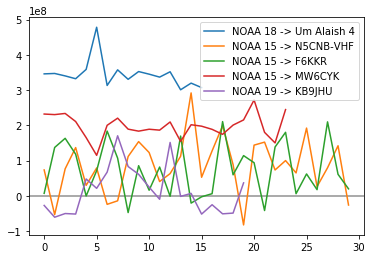

In [9]:
def _get_p_ud(char, start_time, end_time):
    value = 0.0
    for i, c in enumerate(char):
        # The first characteristics entry might be valid earlier than the
        # contact starts. This ensures we only take into account the
        # contact time frame itself.
        char_start = max(
           start_time,
           c[0],
        )
        try:
            char_end = min(
                end_time,
                char[i + 1][0],
            )
        except IndexError:
            # The end of the last entry is the contact end time.
            char_end = end_time
        if char_end <= char_start:
            continue
        value += (char_end - char_start) * c[1]
        if char_end == end_time:
            break
    return value

# MIN ELEV TEST WITH VOLUME

result = {}
plt.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = ftvg.edges[(txn, rxn)]
    tp = trajectory_predictors[frozenset([txn, rxn])]
    pred = volume.MinElevationVolumePredictor(tp, min_elevation=10)
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        # usable duration
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
    plt.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
plt.legend()

MEG = 8000000
for pair, r in result.items():
    print(pair, np.mean(r) / MEG, np.std(r) / MEG)
rr = [x for _, r in result.items() for x in r]
print(f"ALL: {np.mean(rr) / MEG}, std = {np.std(rr) / MEG}")

-> Contact #5 (NOAA 18 -> Um Alaish 4) at 1578589693.0: delta = 22.513, usable = 11.1857, predicted = 33.6987
-> Contact #6 (NOAA 18 -> Um Alaish 4) at 1579069101.0: delta = -7.2438, usable = 33.2441, predicted = 26.0004
-> Contact #15 (NOAA 18 -> Um Alaish 4) at 1580017773.0: delta = -7.8335, usable = 33.3528, predicted = 25.5193
-> Contact #9 (NOAA 15 -> N5CNB-VHF) at 1578581133.0: delta = 24.6762, usable = 33.9168, predicted = 58.593
-> Contact #12 (NOAA 15 -> N5CNB-VHF) at 1578660056.0: delta = -27.0175, usable = 40.3184, predicted = 13.3009
-> Contact #14 (NOAA 15 -> N5CNB-VHF) at 1578700542.0: delta = 14.3877, usable = 6.7228, predicted = 21.1105
-> Contact #17 (NOAA 15 -> N5CNB-VHF) at 1578791328.0: delta = 19.6874, usable = 44.2262, predicted = 63.9136
-> Contact #18 (NOAA 15 -> N5CNB-VHF) at 1578841839.0: delta = 22.5333, usable = 18.6245, predicted = 41.1578
-> Contact #20 (NOAA 15 -> N5CNB-VHF) at 1578926699.0: delta = 26.1312, usable = 35.6804, predicted = 61.8115
-> Contac

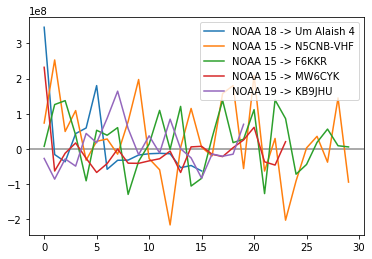

In [10]:
# TriStateVolumePredictorX

result = {}
plt.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = ftvg.edges[(txn, rxn)]
    tp = trajectory_predictors[frozenset([txn, rxn])]
    pred = volume.TriStateVolumePredictor(
        tp,
        link_block_size=LL_BLOCK_SZ,
        averaging_window_size=WND_SZ,
        #az_granularity=360,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        # usable duration
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
        if fc_i > 4 and (vol_pred / vol_fact < 0.8 or vol_pred / vol_fact > 1.2):
            print(f"-> Contact #{fc_i} ({txn} -> {rxn}) at {cur_fc.start_time}: delta = {round((vol_pred - vol_fact) / MEG, 4)}, usable = {round(vol_fact / MEG, 4)}, predicted = {round(vol_pred / MEG, 4)}")
        pred.observe_contact(cur_fc)
    plt.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
plt.legend()

MEG = 8000000
for pair, r in result.items():
    print(pair, np.mean(r) / MEG, np.std(r) / MEG)
rr = [x for _, r in result.items() for x in r]
print(f"ALL: {np.mean(rr) / MEG}, std = {np.std(rr) / MEG}")

('NOAA 18', 'Um Alaish 4') 2.5889733375516206 11.364497450536238
('NOAA 15', 'N5CNB-VHF') 5.120772703512812 20.729375187393266
('NOAA 15', 'F6KKR') -1.7679135538807889 16.512613887035528
('NOAA 15', 'MW6CYK') 0.18554736984780398 7.485289226036256
('NOAA 19', 'KB9JHU') 1.8747119804086612 7.913157999792137
ALL: 1.5329727031192264, std = 14.863685594534317


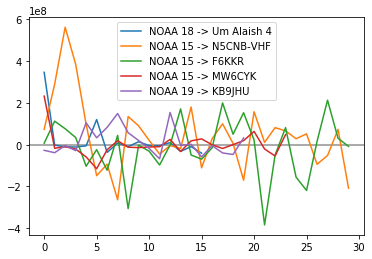

In [11]:
# TwoStateVolumePredictor2

result = {}
plt.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = ftvg.edges[(txn, rxn)]
    tp = trajectory_predictors[frozenset([txn, rxn])]
    pred = volume.TwoStateVolumePredictor(
        tp,
        link_block_size=LL_BLOCK_SZ,
        averaging_window_size=WND_SZ,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        # usable duration
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
        pred.observe_contact(cur_fc)
    plt.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
plt.legend()

MEG = 8000000
for pair, r in result.items():
    print(pair, np.mean(r) / MEG, np.std(r) / MEG)
rr = [x for _, r in result.items() for x in r]
# TODO: percentile for difference
print(f"ALL: {np.mean(rr) / MEG}, std = {np.std(rr) / MEG}")

In [ ]:
# Xpred

from predictutil.volume import XPredBasedVolumePredictor

rate = cur_fc.to_simple().bit_rate
plt.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = ftvg.edges[(txn, rxn)]
    tp = trajectory_predictors[frozenset([txn, rxn])]
    pred = XPredBasedVolumePredictor(
        tp,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        cur_pc = get_contact(ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        # usable duration
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
        pred.observe_contact(cur_fc)
    plt.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
plt.legend()

MEG = 8000000
for pair, r in result.items():
    print(pair, np.mean(r) / MEG, np.std(r) / MEG)
rr = [x for _, r in result.items() for x in r]
print(f"ALL: {np.mean(rr) / MEG}, std = {np.std(rr) / MEG}")

In [ ]:
txn, rxn = ("NOAA 18", "Um Alaish 4")
e_fcp = ftvg.edges[(txn, rxn)]
#print(e_fcp[0])
tp = trajectory_predictors[frozenset([txn, rxn])]
tp.predict_contacts_ex(
    1578418146.4641266 + 300,
    1578418146.4641266,
    1578419105.338229,
    10,
)
tp.predict_max_elevation(1578418146.4641266,
    1578419105.338229,)[1] * 180 / math.pi

In [ ]:
# This tests the accuracy of get_fc_volume by doing a Monte-Carlo simulation.
# Result: very good

import random

# FIXME: CCSDS BLOCK SIZE
BLOCK_SZ = 1500 * 8

def fc_volume_monte_carlo(fc, size, iterations):
    block_count = 0
    for i in range(iterations):
        time = fc.start_time
        while time < fc.end_time:
            cur_char = fc.get_characteristics_at(time)
            p_block_successfully_transmitted = (
                (1 - cur_char.bit_error_rate) ** size
            )
            tx_duration = size / cur_char.bit_rate
            if time + tx_duration > fc.end_time:
                break
            if random.random() < p_block_successfully_transmitted:
                block_count += 1
            time += tx_duration
    return (block_count / iterations) * size

for _ in range(10):
    cur_fc = random.choice(fcp)
    estv = get_fc_volume(cur_fc, BLOCK_SZ)
    simv = fc_volume_monte_carlo(cur_fc, BLOCK_SZ, 20)
    print(round((estv - simv) / estv, 6))

Loaded scenario: 1 gs, 3 sat
FCP has len = 82
F-TVG has 4 vertices and 6 edges


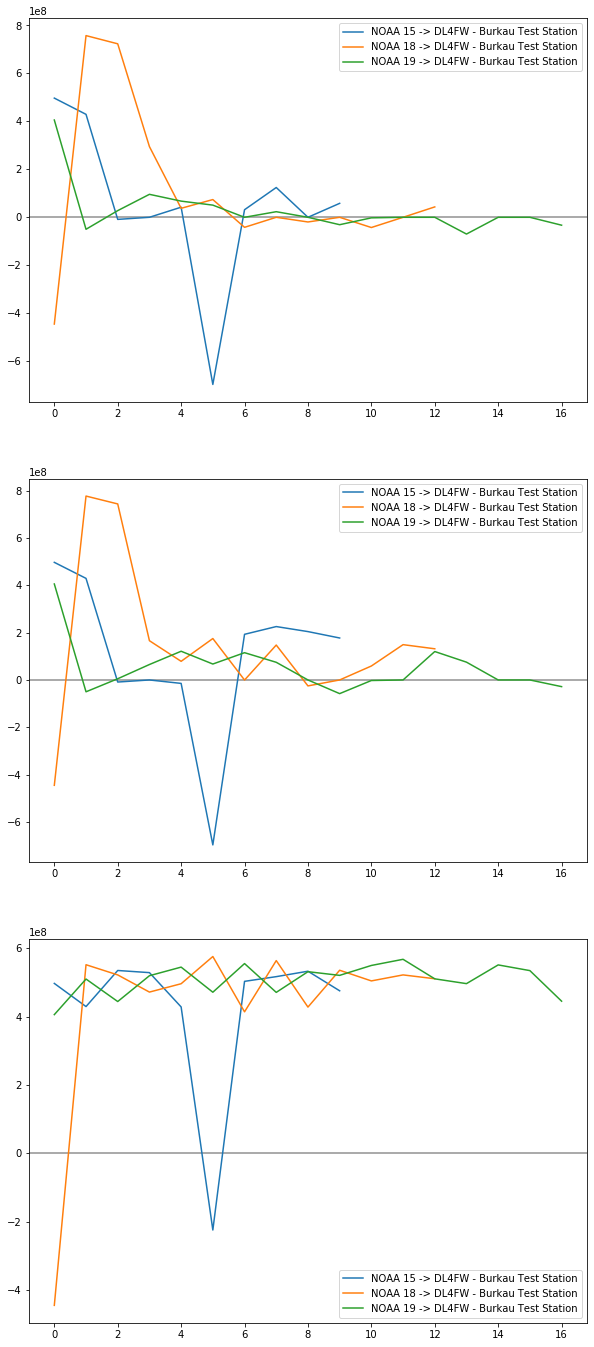

In [20]:
with open("../cache.out/dl4fw/dl4fw.02.scenario.json", "r") as f:
    dl4fw_scenario = json.load(f)
      
dl4fw_gs_list = dl4fw_scenario["gslist"]
dl4fw_sat_list = dl4fw_scenario["satlist"]

with open("../cache.out/dl4fw/dl4fw.02.ftvg.json", "r") as f:
    dl4fw_ftvg = tvg.from_serializable(json.load(f))
    
dl4fw_fcp = tvg.to_contact_plan(dl4fw_ftvg)

print(f"Loaded scenario: {len(dl4fw_gs_list)} gs, {len(dl4fw_sat_list)} sat")
print(f"FCP has len = {len(dl4fw_fcp)}")
print(f"F-TVG has {len(dl4fw_ftvg.vertices)} vertices and {len(dl4fw_ftvg.edges)} edges")

dl4fw_trajectory_predictors = {
        frozenset((gs["id"], sat["id"])): SatelliteTrajectoryPredictor(
            sat["id"],
            sat["tle_list"],
            gs["lat"],
            gs["lon"],
            gs["alt"],
        )
        for gs, sat in itertools.product(dl4fw_gs_list, dl4fw_sat_list)
}

dl4fw_scenario_start = min(dl4fw_fcp, key=attrgetter("start_time")).start_time
dl4fw_scenario_end = max(dl4fw_fcp, key=attrgetter("end_time")).end_time

dl4fw_rr0_contacts = predict_rr0_for_scenario(
    dl4fw_gs_list,
    dl4fw_sat_list,
    dl4fw_scenario_start,
    dl4fw_scenario_end,
    0,  # NOTE: minelev for PCP is 0 because we modify the predictions!
)
dl4fw_rr0_contacts = [
    (gs, sat, start, end)
    for gs, sat, start, end in dl4fw_rr0_contacts
    if get_contact(dl4fw_ftvg.edges.get((gs, sat), []), start, end)
]
# WARNING: uplink_rate is from first entry of tuple to second (GS -> Sat)
dl4fw_pcp = contact_plan.contact_tuples_to_pcp(
    dl4fw_rr0_contacts,
    0.0,
    uplink_rate=dl4fw_scenario["bit_rate_uplink"],
    downlink_rate=dl4fw_scenario["bit_rate_downlink"],
)
dl4fw_ptvg = tvg.from_contact_plan(dl4fw_pcp)

C_COUNT = 20
DL4FW_NAME = "DL4FW - Burkau Test Station"
PAIRS = [
    ("NOAA 15", DL4FW_NAME),
    ("NOAA 18", DL4FW_NAME),
    ("NOAA 19", DL4FW_NAME),
]
# TLE are recorded with the time of the FC for which they were first used
# we thus retrieve TLE from "the future" which are actually much closer to the TLE used for predicting the contact
PREDICT_OFFSET_TIME = 86400
LL_BLOCK_SZ = 1500 * 8

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 24))

result = {}
ax1.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = dl4fw_ftvg.edges[(txn, rxn)]
    tp = dl4fw_trajectory_predictors[frozenset([txn, rxn])]
    pred = volume.TwoStateVolumePredictor(
        tp,
        link_block_size=LL_BLOCK_SZ,
        averaging_window_size=WND_SZ,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(dl4fw_ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        if not cur_pc:
            continue
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        # usable duration
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
        pred.observe_contact(cur_fc)
    ax1.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
ax1.legend()

result = {}
ax2.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = dl4fw_ftvg.edges[(txn, rxn)]
    tp = dl4fw_trajectory_predictors[frozenset([txn, rxn])]
    pred = volume.TriStateVolumePredictor(
        tp,
        link_block_size=LL_BLOCK_SZ,
        averaging_window_size=WND_SZ,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(dl4fw_ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        if not cur_pc:
            continue
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        # usable duration
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
        pred.observe_contact(cur_fc)
    ax2.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
ax2.legend()

result = {}
ax3.axhline(y=0, color="#909090")
for txn, rxn in PAIRS:
    e_fcp = dl4fw_ftvg.edges[(txn, rxn)]
    tp = dl4fw_trajectory_predictors[frozenset([txn, rxn])]
    pred = volume.MinElevationVolumePredictor(
        tp,
        min_elevation=10,
    )
    result[(txn, rxn)] = []
    for fc_i, cur_fc in enumerate(e_fcp[0:C_COUNT]):
        rate = cur_fc.to_simple().bit_rate
        cur_pc = get_contact(dl4fw_ptvg.edges[(txn, rxn)], cur_fc.start_time, cur_fc.end_time)
        if not cur_pc:
            continue
        vol_fact = get_fc_volume(cur_fc, LL_BLOCK_SZ)
        drf = pred.predict_data_rate_factors(cur_fc.start_time + PREDICT_OFFSET_TIME, cur_pc.start_time, cur_pc.end_time)
        # usable duration
        ud_pred = _get_p_ud(drf, cur_pc.start_time, cur_pc.end_time)
        vol_pred = ud_pred * rate
        result[(txn, rxn)].append(vol_pred - vol_fact)
        pred.observe_contact(cur_fc)
    ax3.plot(list(range(len(result[(txn, rxn)]))), result[(txn, rxn)], label=f"{txn} -> {rxn}")
ax3.legend()

{}